# Gender Classification
Train a simple gender classification model.
The model will guess either male or female by the given 88 GeMAPS features.

In [18]:
# Imports
# Python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import shap

from joblib import dump,load
from skl2onnx import to_onnx

import IPython.display as ipd
import seaborn as sns

In [2]:
rand_state = 10

# Load the data
First we need the dataset we're going to work on.
Get the dataframes by the local csvs and merge them into a df we can work with for ml

In [3]:
voices_path = "../data/csv_saves/gemaps/voices.csv"
features_path = "../data/csv_saves/gemaps/features.csv"
model_path = "../data/models/randomforest/"
audio_path = "/home/chr1s/Downloads/cv-corpus-21.0-2025-03-14/en/clips/"

In [4]:
voices = pd.read_csv(voices_path)
features = pd.read_csv(features_path)
voices.head()

,clip_id,audio_file_name,voice_name,voice_age,voice_age_group,voice_gender,features_extracted
0,3d060d83-adbd-44e0-afce-b826aa5381b1,common_voice_en_19666343.mp3,20_m_0b062,NaN,20,m,True
1,ecd475b2-3015-4ce5-a2fe-81534bf945b0,common_voice_en_23711401.mp3,30_m_89b1e,NaN,30,m,True
2,01374f0c-ff48-4663-a42d-08c4f184e299,common_voice_en_27285325.mp3,30_m_b229e,NaN,30,m,True
3,4c985ac7-9e16-4dc9-9c45-2127a16fe7fe,common_voice_en_216280.mp3,20_m_6603d,NaN,20,m,True
4,e878a03f-b309-4197-8e87-40b42e5c431d,common_voice_en_35888106.mp3,30_m_bdd6a,NaN,30,m,True


In [5]:
# Merge voices and features by the column "clip_id"
data = pd.merge(voices[["clip_id", "voice_gender"]], features, on="clip_id")
data.set_index("clip_id", inplace=True)
del voices

In [6]:
data.head()

,voice_gender,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
clip_id,,,,,,,,,,,,,,,,,,,,,
3d060d83-adbd-44e0-afce-b826aa5381b1,m,22.179844,0.339790,18.409922,20.131195,23.650680,5.240759,266.153960,232.235800,103.508570,...,0.031013,0.002345,0.413786,4.216867,2.231237,0.266364,0.171213,0.193333,0.241707,-21.007450
ecd475b2-3015-4ce5-a2fe-81534bf945b0,m,24.322006,0.580217,16.880875,18.579967,21.307907,4.427032,398.797424,396.038849,428.149078,...,0.017557,-0.001341,0.670560,4.521739,4.035088,0.130870,0.100733,0.133750,0.138829,-22.155727
01374f0c-ff48-4663-a42d-08c4f184e299,m,24.174156,0.338320,19.873123,21.779720,25.701950,5.828827,657.793335,725.710876,132.189041,...,0.035306,-0.002314,0.359165,3.954802,3.612167,0.151053,0.126195,0.110000,0.161417,-21.083681
4c985ac7-9e16-4dc9-9c45-2127a16fe7fe,m,24.890310,0.161558,22.497490,26.137222,27.981504,5.484015,115.091469,60.737309,107.501930,...,0.075598,0.002145,0.150634,2.822581,1.239670,0.556667,0.332499,0.170000,0.123491,-18.839119
e878a03f-b309-4197-8e87-40b42e5c431d,m,30.156759,0.309775,23.325962,32.324020,34.654331,11.328369,81.758034,38.350334,310.445709,...,0.064182,0.021776,0.155598,2.553192,2.178649,0.129000,0.117000,0.308000,0.364357,-28.008059


<Axes: >

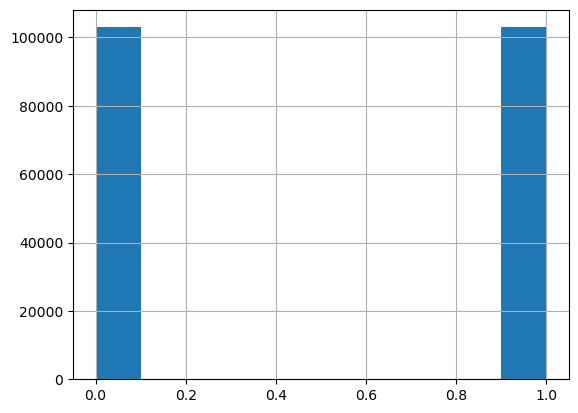

In [7]:
# turn gender into a binary variable
data["voice_gender_m"] = data["voice_gender"].apply(lambda x: 1 if x == "m" else 0)
data["voice_gender_f"] = data["voice_gender"].apply(lambda x: 1 if x == "f" else 0)
data.drop(columns="voice_gender", inplace=True)
data.voice_gender_m.hist()

# Understand data
Next we need to get an even better understanding of the data...

In [ ]:
data.info()

In [ ]:
data.describe()

#### Correlation
Lets correllate the features with the gender.
This gives us some basic informations which features could be relevant for gender detection.

In [ ]:
"""
corr = data.corr()
target_cols = ["voice_gender_m", "voice_gender_f"]
corr_with_targets = corr[target_cols]
top_features = set()
for col in target_cols:
    abs_corr = corr_with_targets[col].abs().drop(target_cols, errors='ignore')
    abs_corr = abs_corr[abs_corr < 1.0]
    top_features.update(abs_corr.nlargest(10).index.tolist())
top_features.update(target_cols)
top_features_list = list(top_features)
subset_corr = corr.loc[top_features_list, top_features_list]
plt.figure(figsize=(12, 10))
sns.heatmap(subset_corr, annot=True, fmt=".2f", cmap="coolwarm", 
            vmin=-1, vmax=1, center=0)
plt.title("Top Correlations with Voice Gender Features")
plt.tight_layout()
plt.show()
"""

In [ ]:
"""
corr_table = corr_with_targets.loc[top_features_list].stack().reset_index()
corr_table.columns = ['Feature', 'Gender', 'Correlation']
corr_table['Abs_Correlation'] = corr_table['Correlation'].abs()
corr_table = corr_table.sort_values('Abs_Correlation', ascending=False)
display(corr_table[['Feature', 'Gender', 'Correlation']].style
        .background_gradient(cmap='coolwarm', subset=['Correlation'])
        .format({'Correlation': '{:.2f}'})
        .set_caption('Top Correlations with Voice Gender Features'))
"""

#### Random Forest Classifier
Lets create a random forest model to try classifing the gender by the audio features 

In [8]:
# create features and labels
target_cols = ["voice_gender_m", "voice_gender_f"]
X = data.drop(columns=target_cols)
y = data["voice_gender_m"]

In [ ]:
# Select features for grid search
forest_feature_grid = {
    "n_estimators": [10, 100, 1000],
    "max_depth": [5, 10, 15],
}

In [ ]:
"""
# grid search the best parameters
forest = RandomForestClassifier(random_state=rand_state)
forest_grid = GridSearchCV(forest, forest_feature_grid, verbose=2, cv=1)
forest_grid.fit(X, y)
"""

#### Train a Random Forest with fitting parameters
If I have time I'll promise to use GridSearch for this ^^"

In [9]:
target_cols = ["voice_gender_m", "voice_gender_f"]
X = data.drop(columns=target_cols)
y = data["voice_gender_m"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [11]:
forest = RandomForestClassifier(
    n_estimators=500,
    max_depth=5,
    random_state=rand_state,
)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500, random_state=10)

In [12]:
y_train_pred = forest.predict(X_train)
y_train_pred_proba = forest.predict_proba(X_train)[:, 1]
y_test_pred = forest.predict(X_test)
y_test_pred_proba = forest.predict_proba(X_test)[:, 1]

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.9214
Test Accuracy: 0.9197


In [13]:
(y_test - y_test_pred_proba).abs().describe()

count    41188.000000
mean         0.177122
std          0.185539
min          0.042276
25%          0.068703
50%          0.101221
75%          0.192626
max          0.955435
Name: voice_gender_m, dtype: float64

In [14]:
feature_importances = pd.DataFrame(forest.feature_importances_, columns=["feature_importance"], index=X_train.columns)
feature_importances.sort_values(by="feature_importance", ascending=False, inplace=True)
feature_importances

,feature_importance
F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.233666
F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.173262
F0semitoneFrom27.5Hz_sma3nz_amean,0.138251
F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.136181
HNRdBACF_sma3nz_amean,0.076601
...,...
F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,0.000020
loudness_sma3_stddevNorm,0.000011
loudness_sma3_stddevFallingSlope,0.000008
F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,0.000006


In [ ]:
"""
# Save the model to a onnx file
onx = to_onnx(forest, X_train[:1].values.astype(np.float32), target_opset=12)

with open(os.path.join(model_path, "random_forest_model.onnx"), "wb") as f:
    f.write(onx.SerializeToString())
"""

In [19]:
# Save the model to a joblib file and load it again
dump(forest, os.path.join(model_path, "random_forest_model.joblib"))
forest = load(os.path.join(model_path, "random_forest_model.joblib"))

# Time for SHAP!
Lets see what the model thinks about features! 

In [20]:
i = 10
clip_id = X_test.index[i]
print(clip_id)
print(X_test.loc[clip_id,:], "\n")
print(f"Model prediction: {y_test_pred[i]}, probability: {y_test_pred_proba[i]:.4f}, true label: {y_test.iloc[i]}")

f44c2f61-96e9-46db-9ab2-f2a9cedf1388
F0semitoneFrom27.5Hz_sma3nz_amean             35.031105
F0semitoneFrom27.5Hz_sma3nz_stddevNorm         0.145915
F0semitoneFrom27.5Hz_sma3nz_percentile20.0    31.647015
F0semitoneFrom27.5Hz_sma3nz_percentile50.0    36.724445
F0semitoneFrom27.5Hz_sma3nz_percentile80.0    38.824860
                                                ...    
MeanVoicedSegmentLengthSec                     0.314286
StddevVoicedSegmentLengthSec                   0.211042
MeanUnvoicedSegmentLength                      0.755000
StddevUnvoicedSegmentLength                    1.171448
equivalentSoundLevel_dBp                     -18.230164
Name: f44c2f61-96e9-46db-9ab2-f2a9cedf1388, Length: 88, dtype: float64 

Model prediction: 0, probability: 0.0565, true label: 0


In [21]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_test.iloc[i])

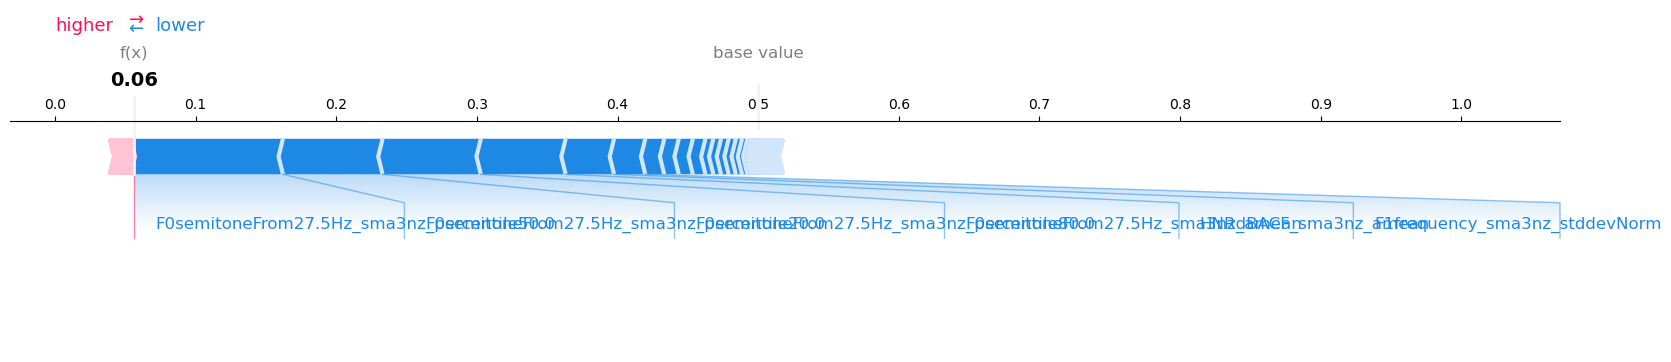

In [22]:
shap.force_plot(explainer.expected_value[1], shap_values[:, 1], feature_names=X_test.columns, matplotlib=True)

In [23]:
explainer = shap.Explainer(forest, X_train)
shap_values = explainer(X_test[:1000], check_additivity=False)

 97%|=================== | 1945/2000 [00:30<00:00]       

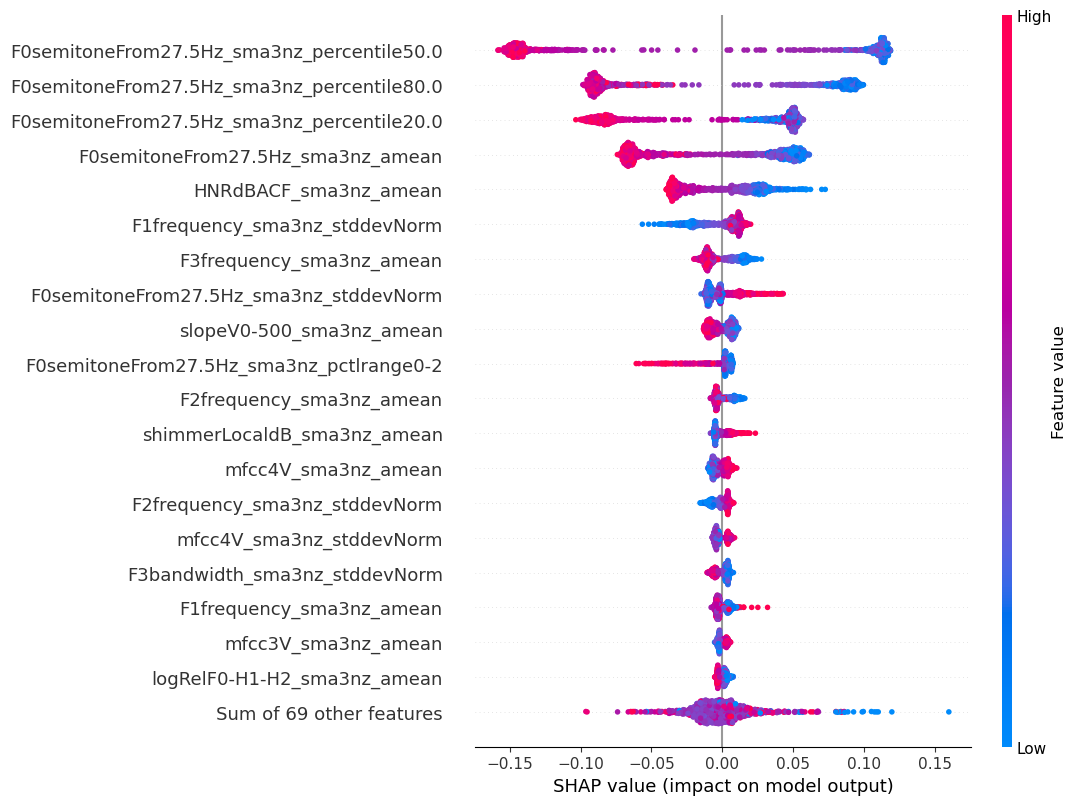

In [25]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=20)